In [1]:
%matplotlib inline

**Requirements**



In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
from collections import OrderedDict
import unicodedata
import string
import re
import random
import numpy as np
import pickle as pkl
import spacy
nlp = spacy.load('en')

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

**Settings**

In [3]:
ORDER = 2
NUM_WORDS = 10000

**Preprocessing Data**

In [4]:
SOS_token = 0
EOS_token = 1

def extract_ngrams(vocab, sent, order):
    ngrams = []
    
    # tokenization
    uwords = [t.text for t in nlp(str(sent))]
    
    # extract ngrams
    for oo in range(1, order + 1):
        for ng in set([' '.join(t).strip() for t in zip(*[uwords[i:] for i in range(oo)])]):
            ngrams.append(ng)
            if ng in vocab:
                vocab[ng] += 1
            else:
                vocab[ng] = 1


    return vocab, ngrams

class Lang:
    def __init__(self, name, order):
        self.name = name
        
        # for single words
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS
        
        # for ngrams
        self.order = order
        self.vocab0 = OrderedDict()

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
        self.vocab0, ngrams = extract_ngrams(self.vocab0, sentence, self.order)
        return ngrams

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    
    def createNGramDictionary(self):
        tokens = list(self.vocab0.keys())
        freqs = list(self.vocab0.values())
        sidx = np.argsort(freqs)[::-1]
        vocab = OrderedDict([(tokens[s], i) for i, s in enumerate(sidx)])
        return vocab

In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [6]:
def readLangs(lang1, lang2, order, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2, order)
        output_lang = Lang(lang1, order)
    else:
        input_lang = Lang(lang1, order)
        output_lang = Lang(lang2, order)

    return input_lang, output_lang, pairs

In [7]:
MAX_LENGTH = 7

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [8]:
def prepareData(lang1, lang2, order, reverse=False):
    data = []
    input_lang, output_lang, pairs = readLangs(lang1, lang2, order, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        #input_lang.addSentence(pair[0])
        pair[0] = output_lang.addSentence(pair[1])

    print("Counted words:")
#     print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', ORDER, True)
vocab_ngrams = output_lang.createNGramDictionary()
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 5412 sentence pairs
Counting words...
Counted words:
eng 1644
[['we', 're', 'just', '.', 'scared', 'just scared', 're just', 'scared .', 'we re'], 'we re just scared .']


In [9]:
len(vocab_ngrams)

6711

The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <http://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

.. figure:: /_static/img/seq-seq-images/encoder-network.png
   :alt:





In [10]:
# class EncoderRNN(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(EncoderRNN, self).__init__()
#         self.hidden_size = hidden_size

#         self.embedding = nn.Embedding(input_size, hidden_size)
#         self.gru = nn.GRU(hidden_size, hidden_size)

#     def forward(self, input, hidden):
#         embedded = self.embedding(input).view(1, 1, -1)
#         output = embedded
#         output, hidden = self.gru(output, hidden)
#         return output, hidden

#     def initHidden(self):
#         result = Variable(torch.zeros(1, 1, self.hidden_size))
#         if use_cuda:
#             return result.cuda()
#         else:
#             return result

class NGramEncoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NGramEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
    
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        hidden = hidden + embedded
        return output, hidden
    
    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




Simple Decoder
^^^^^^^^^^^^^^

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

.. figure:: /_static/img/seq-seq-images/decoder-network.png
   :alt:





In [11]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




Attention Decoder
^^^^^^^^^^^^^^^^^

If only the context vector is passed betweeen the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

.. figure:: https://i.imgur.com/1152PYf.png
   :alt:

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

.. figure:: /_static/img/seq-seq-images/attention-decoder-network.png
   :alt:





In [12]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH*ORDER):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

# Training

## Preparing Training Data

In [13]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result


def indexesFromNGramList(vocab, ngram_list, order, num_words):
    result = []
    for ng in ngram_list:
        if ng in vocab:
            idx = vocab[ng]
            if idx > num_words:
                pass
            else:
                result.append(idx)
        else:
            pass
    return result
    
    
def variableFromNGramList(vocab, ngram_list, order, num_words):
    indexes = indexesFromNGramList(vocab, ngram_list, order, num_words)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result
    
    
def variablesFromPair(pair):
    input_variable = variableFromNGramList(vocab_ngrams, pair[0], ORDER, NUM_WORDS)
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

In [14]:
print(pairs[100])
print(variablesFromPair(pairs[100]))
print(indexesFromSentence(output_lang, 'i m shy .'))

[['m', '.', 'i', 'going', 'going .', 'i m', 'm going'], 'i m going .']
(Variable containing:
    5
    0
    3
   46
  480
    6
  141
[torch.cuda.LongTensor of size 7x1 (GPU 0)]
, Variable containing:
  2
  3
 61
  4
  1
[torch.cuda.LongTensor of size 5x1 (GPU 0)]
)
[2, 3, 12, 4]


Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>`__.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [15]:
teacher_forcing_ratio = 0.5


def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH*ORDER):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
#             decoder_output, decoder_hidden = decoder(
#                 decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
#             decoder_output, decoder_hidden = decoder(
#                 decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [16]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [17]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [19]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH*ORDER):
    input_variable = variableFromNGramList(vocab_ngrams, sentence, ORDER, NUM_WORDS)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
#         decoder_output, decoder_hidden = decoder(
#             decoder_input, decoder_hidden)
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words, decoder_attentions[:di + 1]
#     return decoded_words

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [20]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
#         output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




In [21]:
# hidden_size = 256
# encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
# attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1)

# if use_cuda:
#     encoder1 = encoder1.cuda()
#     attn_decoder1 = attn_decoder1.cuda()

# trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

hidden_size = 100
encoder1 = NGramEncoder(NUM_WORDS, hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1)

if use_cuda:
    encoder1 = encoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()

In [22]:
evaluateRandomly(encoder1, attn_decoder1)

> ['japanese', 'you', '.', 'not', 'are', 'you are', 'japanese .', 'not japanese', 'are not']
= you are not japanese .
< i terrified father father nervous father nervous house american course course freshman swiss freshman

> ['close', 'friend', 'he', '.', 'my', 'is', 'is my', 'my close', 'he is', 'friend .', 'close friend']
= he is my close friend .
< addict addict addict addict fooling fooling fooling fooling nature obstinate obstinate attack attack oddly

> ['.', 'expensive', 're', 'they', 'not', 'expensive .', 're not', 'they re', 'not expensive']
= they re not expensive .
< portugal portugal now now comedians north north north north north north turning turning nature

> ['i', 'good', '.', 'am', 'math', 'at', 'at math', 'math .', 'good at', 'i am', 'am good']
= i am good at math .
< writing finally finally finally starved starved aren fooling fooling fooling will turning freshman fussy

> ['liar', 'a', 'bad', 's', 'he', '.', 's a', 'he s', 'a bad', 'liar .', 'bad liar']
= he s a bad

0m 42s (- 34m 26s) (1000 2%) 2.6158
1m 16s (- 30m 28s) (2000 4%) 2.0001
1m 50s (- 28m 47s) (3000 6%) 1.7082
2m 24s (- 27m 42s) (4000 8%) 1.4472
2m 59s (- 26m 52s) (5000 10%) 1.2728
3m 32s (- 25m 59s) (6000 12%) 1.1229
4m 7s (- 25m 17s) (7000 14%) 1.0333
4m 40s (- 24m 32s) (8000 16%) 0.8566
5m 15s (- 23m 56s) (9000 18%) 0.8364
5m 50s (- 23m 20s) (10000 20%) 0.7272
6m 25s (- 22m 45s) (11000 22%) 0.6243
6m 59s (- 22m 9s) (12000 24%) 0.6236
7m 34s (- 21m 34s) (13000 26%) 0.5349
8m 10s (- 21m 0s) (14000 28%) 0.5195
8m 45s (- 20m 25s) (15000 30%) 0.4567
9m 20s (- 19m 50s) (16000 32%) 0.4100
9m 55s (- 19m 15s) (17000 34%) 0.3841
10m 30s (- 18m 40s) (18000 36%) 0.3668
11m 5s (- 18m 5s) (19000 38%) 0.3330
11m 40s (- 17m 30s) (20000 40%) 0.3498
12m 15s (- 16m 55s) (21000 42%) 0.3300
12m 50s (- 16m 21s) (22000 44%) 0.2483
13m 25s (- 15m 45s) (23000 46%) 0.2734
14m 0s (- 15m 10s) (24000 48%) 0.2282
14m 35s (- 14m 35s) (25000 50%) 0.2160
15m 10s (- 14m 0s) (26000 52%) 0.1633
15m 45s (- 13m 25s) (27

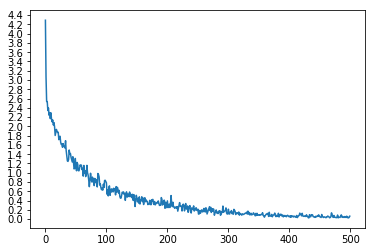

In [23]:
trainIters(encoder1, attn_decoder1, 50000, print_every=1000)

In [24]:
evaluateRandomly(encoder1, attn_decoder1)

> ['i', 'observant', 'm', '.', 'm observant', 'observant .', 'i m']
= i m observant .
< i m observant . <EOS>

> ['.', 'getting', 'we', 're', 'closer', 'getting closer', 'closer .', 'we re', 're getting']
= we re getting closer .
< we re getting closer . <EOS>

> ['.', 'you', 're', 'early', 're early', 'you re', 'early .']
= you re early .
< you re early . <EOS>

> ['i', 'a', 'am', 'muslim', '.', 'a muslim', 'am a', 'i am', 'muslim .']
= i am a muslim .
< i am a muslim . <EOS>

> ['different', 'you', 're', 'no', '.', 'you re', 'different .', 're no', 'no different']
= you re no different .
< you re no different . <EOS>

> ['.', 'japanese', 'she', 'well', 'spoke', 'she spoke', 'well .', 'japanese well', 'spoke japanese']
= she spoke japanese well .
< she spoke japanese japanese . <EOS>

> ['i', 'retired', 'too', 'm', '.', 'retired too', 'i m', 'm retired', 'too .']
= i m retired too .
< i m retired too . <EOS>

> ['.', 'we', 're', 'overreacting', 're overreacting', 'we re', 'overreactin

In [23]:
#extract as list, not set
def ngram_extractor_eval(sent, order=1):
    ngrams = []
    
    # tokenization
    uwords = [t.text for t in nlp(str(sent))]
    
    # extract ngrams
    for oo in range(1, order + 1):
        for ng in ([' '.join(t).strip() for t in zip(*[uwords[i:] for i in range(oo)])]):
            ngrams.append(ng)
            
    return ngrams


#ROUGE Score, match/reference length
def ROUGE(cand, ref, n=ORDER):
    cand_ngrams = ngram_extractor_eval(cand, n)
    ref_ngrams = ngram_extractor_eval(ref, n)
    count = 0
    for gram in ref_ngrams:
        if gram in cand_ngrams:
            count += 1
    return count/len(cand_ngrams)

#BLEU Score, match/candidate length, without clipping
def BLEU(cand, ref, n=ORDER):
    cand_ngrams = ngram_extractor_eval(cand, n)
    ref_ngrams = ngram_extractor_eval(ref, n)
    count = 0
    for gram in cand_ngrams:
        if gram in ref_ngrams:
            count += 1
    return count/len(ref_ngrams)

def BLEU_clip(cand, ref, n=ORDER):
    cand_ngrams = ngram_extractor_eval(cand, n)
    ref_ngrams = ngram_extractor_eval(ref, n)
    l = len(ref_ngrams)
    count = 0
    for gram in cand_ngrams:
        if gram in ref_ngrams:
            count += 1
            ref_ngrams.remove(gram)
    return count/l

#Coherence score is used for paragraphs, not used yet
def Coherence():
    pass

def score(list_cand, list_ref, n=ORDER, method='ROUGE'):
    score = 0
    dic = {'ROUGE':ROUGE, 'BLEU':BLEU, 'BLEU_clip':BLEU_clip}
    fun = dic[method]
    num_sent = len(list_cand)
    for i in range(num_sent):
        score += fun(list_cand[i], list_ref[i], n)
    return score/num_sent

In [34]:
def evaluateRandomlyWithScore(encoder, decoder, n=10, method="ROUGE"):
    list_cand = []
    list_ref = []
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
#         output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        list_cand.append(output_sentence)
        list_ref.append(pair[1])
    print(score(list_cand, list_ref, method=method))

In [35]:
evaluateRandomlyWithScore(encoder1, attn_decoder1)

> ['m', '.', 'i', 'lazy', 'm lazy', 'i m', 'lazy .']
= i m lazy .
< powerless adaptable smiled missed magician magician magician interested creative confused creative weird weird weird

> ['we', 're', 'impressed', 'not', '.', 're not', 'impressed .', 'not impressed', 'we re']
= we re not impressed .
< staying dubious dubious magician magician magician confused exhausted confused analyzing confused analyzing analyzing confused

> ['we', 're', 'all', '.', 'bored', 'all bored', 're all', 'bored .', 'we re']
= we re all bored .
< starting garden accustomed ill head confused confused jump analyzing analyzing confused analyzing strict dinner

> ['very', 're', 'you', '.', 'upset', 'upset .', 're very', 'very upset', 'you re']
= you re very upset .
< joking joking joking fascinating fascinating fascinating fascinating football magician terms football dinner football dinner

> ['re', 'you', 'early', '.', 're early', 'you re', 'early .']
= you re early .
< dinner dinner taking golf jump golf jum

In [37]:
print(score(["i m a management consultant"], ["i m a management person"]))

0.7777777777777778


Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




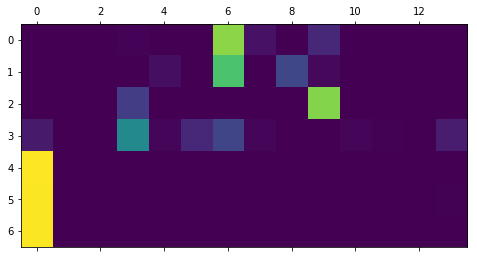

In [25]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "I have a dream .")
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes
and labels:




input = elle a cinq ans de moins que moi .
output = i m a a terrible . <EOS>


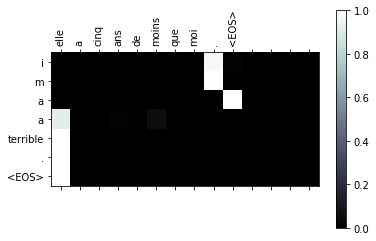

input = elle est trop petit .
output = i m t t cold . <EOS>


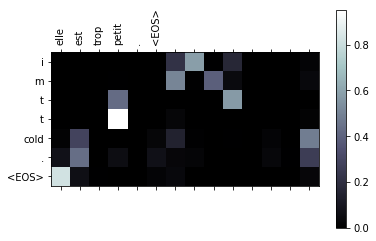

input = je ne crains pas de mourir .
output = i m a a sweetheart . <EOS>


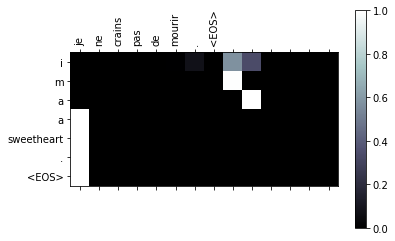

input = c est un jeune directeur plein de talent .
output = i m t t t . <EOS>


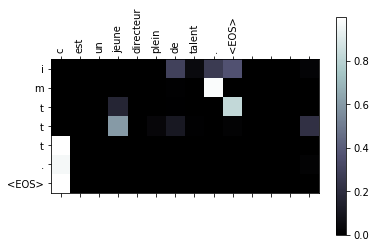

In [26]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

Exercises
=========

-  Try with a different dataset

   -  Another language pair
   -  Human → Machine (e.g. IOT commands)
   -  Chat → Response
   -  Question → Answer

-  Replace the embeddings with pre-trained word embeddings such as word2vec or
   GloVe
-  Try with more layers, more hidden units, and more sentences. Compare
   the training time and results.
-  If you use a translation file where pairs have two of the same phrase
   (``I am test \t I am test``), you can use this as an autoencoder. Try
   this:

   -  Train as an autoencoder
   -  Save only the Encoder network
   -  Train a new Decoder for translation from there


